In [126]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

from keras.src.utils.module_utils import tensorflow


In [174]:
def show_model_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training')
    plt.plot(val_acc, label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training')
    plt.plot(val_loss, label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Configuration

In [127]:
# Define target image size for CNN input
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3  # RGB images
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
IMAGE_PATH = 'data/sorted'
CLASSES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

## Create Data Loaders

In [128]:
# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

# Load validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 909 files belonging to 11 classes.
Using 728 files for training.
Found 909 files belonging to 11 classes.
Using 181 files for validation.


## Analyze class distribution

2024-12-05 17:49:26.220274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-05 17:49:26.281311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


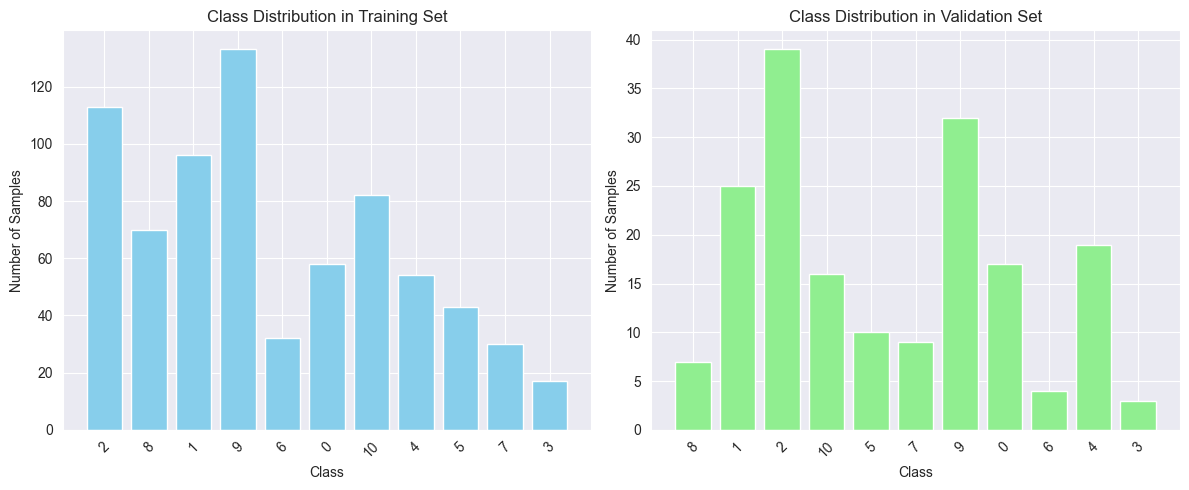

In [129]:
from collections import defaultdict

# Analyze class distribution
def get_class_counts(ds):
    class_names = ds.class_names
    class_counts = defaultdict(int)
    for images, labels in ds:
        labels = labels.numpy()
        for label in labels:
            class_name = class_names[label]
            class_counts[class_name] += 1
    return class_counts

train_class_count = get_class_counts(train_ds)
val_class_count = get_class_counts(validation_ds)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(train_class_count.keys(), train_class_count.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(val_class_count.keys(), val_class_count.values(), color='lightgreen')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Validation Set')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Calculate class weights

In [130]:
total_samples = sum(train_class_count.values())
class_weights = {}

for i, class_name in enumerate(train_class_count):
    class_weights[i] = total_samples / (len(train_class_count) * train_class_count[class_name])

print("\nClass weights:")
print(class_weights)


Class weights:
{0: 0.585679806918745, 1: 0.9454545454545454, 2: 0.6893939393939394, 3: 0.49760765550239233, 4: 2.0681818181818183, 5: 1.141065830721003, 6: 0.8070953436807096, 7: 1.2255892255892256, 8: 1.5391120507399578, 9: 2.206060606060606, 10: 3.893048128342246}


## Split validation dataset

In [131]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

## Split validation dataset

In [132]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## VGG16 model

### Create VGG16 model

In [146]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    weights='imagenet',
    include_top=False,
)

### Configure VGG16 model

In [151]:
from tensorflow.keras import Model

for layer in vgg16.layers[:-3]: layer.trainable = False

input = vgg16.layers[-1].output

x = tf.keras.layers.Dropout(0.25)(input)
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(len(train_ds.class_names), activation='softmax')(x)

vgg16_model = Model(vgg16.input, output)

### Compile VGG16 model

In [159]:
base_learning_rate = 0.0001
vgg16_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

vgg16_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 11)             │       275,979 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,990,667 (57.18 MB)

 Trainable params: 4,995,595 (19.06 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

## Create callbacks

In [157]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint(
        'checkpoints/vgg16_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

### Train VGG16 model

In [160]:
initial_epochs = 10
history = vgg16_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1376 - loss: 27.4050
Epoch 1: val_loss improved from inf to 9.97945, saving model to checkpoints/vgg16_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.1379 - loss: 27.1332 - val_accuracy: 0.1342 - val_loss: 9.9794 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2705 - loss: 6.6429
Epoch 2: val_loss improved from 9.97945 to 4.74319, saving model to checkpoints/vgg16_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.2709 - loss: 6.6123 - val_accuracy: 0.2282 - val_loss: 4.7432 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3908 - loss: 3.3825
Epoch 3: val_loss did not improve from 4.74319
23/23 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.3902 - loss: 3.3848 - val_accuracy: 0.1879 - val_loss: 4.7479 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4752 - l

## Plot training results

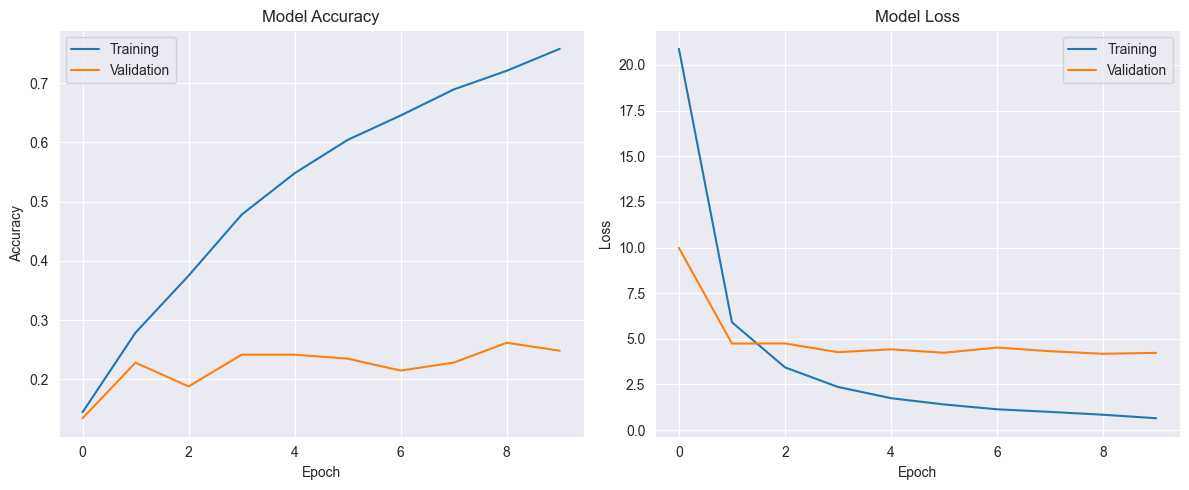

In [162]:
show_model_performance(history)

## Save trained VGG16 model

In [161]:
vgg16_model.save('models/colposcopy_vgg16.keras')
print("Model saved successfully")

Model saved successfully


## Load other models

In [ ]:
custom_model = tf.keras.models.load_model('models/colposcopy_custom.keras')
inception_model = tf.keras.models.load_model('models/colposcopy_model_v2.keras')

In [170]:
# get list of models
models = [custom_model, vgg16_model, inception_model]

## Ensembles

### Configure Concatenated Ensemble

In [ ]:
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout

input = Input(shape=(224, 224, 3), name='input') # input layer

outputs = [model(input) for model in models]

x = Concatenate()(outputs)

x = Dropout(0.5)(x)
output = Dense(len(train_ds.class_names), activation='softmax', name='output')(x) # output layer

conc_model = Model(input, output, name= 'Concatenated_Model')
# show model structure
plot_model(conc_model)

### Compile Concatenated Ensemble model

In [172]:
conc_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

conc_model.summary()

Model: "Concatenated_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Custom_Model        │ (None, 11)        │  5,116,107 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 11)        │ 14,990,667 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_20       │ (None, 11)        │ 22,857,515 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 33)        │          0 │ Custom_Model[0][… │
│ (Concatenate)       │                   │            │ functional_4[0][… │
│                     │                   │            │ functional_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 33)        │          0 │ concatenate[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 11)        │        374 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,964,663 (163.90 MB)

 Trainable params: 32,906,519 (125.53 MB)

 Non-trainable params: 10,058,144 (38.37 MB)

### Train Concatenated Ensemble Model

In [173]:
initial_epochs = 10
history = conc_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0360 - loss: 4.0623
Epoch 1: val_loss improved from 4.18147 to 2.49728, saving model to checkpoints/vgg16_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 197s 8s/step - accuracy: 0.0366 - loss: 4.0609 - val_accuracy: 0.0738 - val_loss: 2.4973 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0559 - loss: 4.0915
Epoch 2: val_loss improved from 2.49728 to 2.49246, saving model to checkpoints/vgg16_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 191s 8s/step - accuracy: 0.0561 - loss: 4.0876 - val_accuracy: 0.0671 - val_loss: 2.4925 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.0442 - loss: 4.1181
Epoch 3: val_loss improved from 2.49246 to 2.43292, saving model to checkpoints/vgg16_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 225s 10s/step - accuracy: 0.0443 - loss: 4.1120 - val_accuracy: 0.1007 - val_loss: 2.4329 - learning_rate: 1.0000e-04
Epoch 4/1

### Save Concatenated Ensemble Model

In [191]:
conc_model.save('models/colposcopy_concat.keras')
print("Model saved successfully")

Model saved successfully


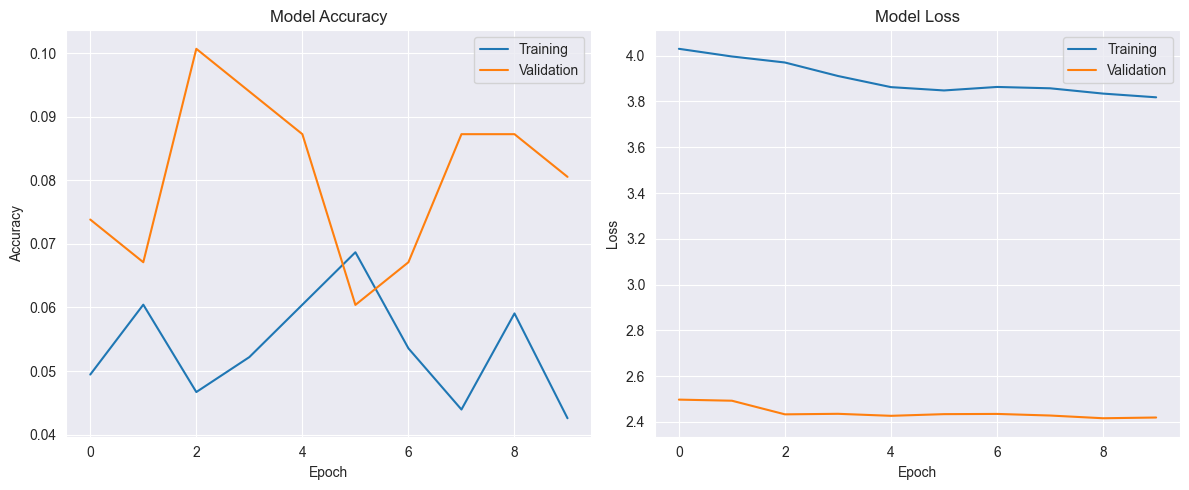

In [183]:
show_model_performance(history)

### Configure Average Ensemble Model

In [184]:
from tensorflow.keras.layers import Average

input = Input(shape=(224, 224, 3), name='input')  # input layer

outputs = [model(input) for model in models]

x = Average()(outputs)

x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(train_ds.class_names), activation='softmax', name='output')(x) # output layer

avg_model = Model(input, output)

# show model structure
plot_model(avg_model)

### Compile Average Ensemble Model

In [186]:
avg_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

avg_model.summary()

Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Custom_Model        │ (None, 11)        │  5,116,107 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 11)        │ 14,990,667 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_20       │ (None, 11)        │ 22,857,515 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_1 (Average) │ (None, 11)        │          0 │ Custom_Model[2][… │
│                     │                   │            │ functional_4[2][… │
│                     │                   │            │ functional_20[2]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 16)        │        192 │ average_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 16)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 11)        │        187 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,964,668 (163.90 MB)

 Trainable params: 32,906,524 (125.53 MB)

 Non-trainable params: 10,058,144 (38.37 MB)

### Train Average Ensemble Model

In [187]:
initial_epochs = 10
history = avg_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1037 - loss: 3.7661
Epoch 1: val_loss improved from 2.41587 to 2.40977, saving model to checkpoints/vgg16_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 224s 9s/step - accuracy: 0.1032 - loss: 3.7635 - val_accuracy: 0.1074 - val_loss: 2.4098 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1053 - loss: 3.7780
Epoch 2: val_loss did not improve from 2.40977
23/23 ━━━━━━━━━━━━━━━━━━━━ 209s 9s/step - accuracy: 0.1050 - loss: 3.7749 - val_accuracy: 0.1074 - val_loss: 2.4124 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1072 - loss: 3.8081
Epoch 3: val_loss did not improve from 2.40977
23/23 ━━━━━━━━━━━━━━━━━━━━ 208s 9s/step - accuracy: 0.1070 - loss: 3.8034 - val_accuracy: 0.0940 - val_loss: 2.4132 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1030 - loss: 3.7326
Epoch 4: val_loss did not improve from 

In [190]:
avg_model.save('models/colposcopy_avg.keras')
print("Model saved successfully")

Model saved successfully


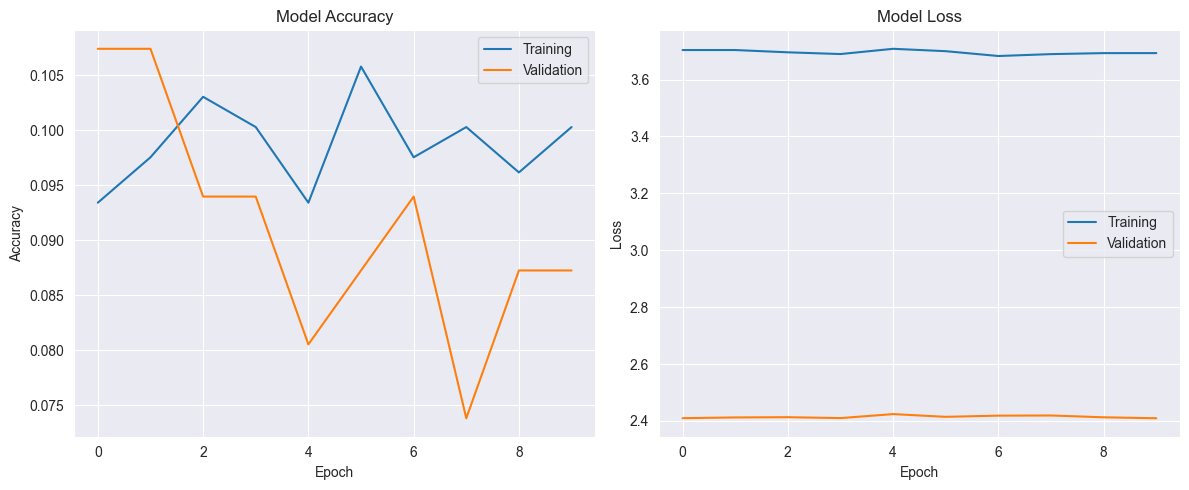

In [192]:
show_model_performance(history)

In [193]:
# function for setting weights

import numpy as np

def weight_init(shape =(1,1,3), weights=[1,2,3], dtype=tf.float32):
    return tf.constant(np.array(weights).reshape(shape), dtype=dtype)

### Implement WeightedAverage layer for Weighted Average Ensemble Model

In [194]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Concatenate

class WeightedAverage(Layer):

    def __init__(self):
        super(WeightedAverage, self).__init__()

    def build(self, input_shape):

        self.W = self.add_weight(
            shape=(1,1,len(input_shape)),
            initializer=weight_init,
            dtype=tf.float32,
            trainable=True
        )

    def call(self, inputs):
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs)
        weights = tf.nn.softmax(self.W, axis=-1)

        return tf.reduce_mean(weights*inputs, axis=-1)

### Configure Weighted Average Ensemble Model

In [195]:
input = Input(shape=(224, 224, 3), name='input')  # input layer

# get output for each input model
outputs = [model(input) for model in models]

# get weighted average of outputs
x = WeightedAverage()(outputs)

output = Dense(len(train_ds.class_names), activation='softmax')(x) # output layer

weighted_avg_model = Model(input, output, name= 'Weighted_AVerage_Model')
# show model structure
plot_model(weighted_avg_model)

### Compile Weighted Average Ensemble Model

In [198]:
weighted_avg_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

weighted_avg_model.summary()

Model: "Weighted_AVerage_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Custom_Model        │ (None, 11)        │  5,116,107 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 11)        │ 14,990,667 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_20       │ (None, 11)        │ 22,857,515 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_average    │ (None, 11)        │          3 │ Custom_Model[3][… │
│ (WeightedAverage)   │                   │            │ functional_4[3][… │
│                     │                   │            │ functional_20[3]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 11)        │        132 │ weighted_average… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,964,424 (163.90 MB)

 Trainable params: 32,906,280 (125.53 MB)

 Non-trainable params: 10,058,144 (38.37 MB)

### Train Weighted Average Ensemble Model

In [199]:
initial_epochs = 10
history = weighted_avg_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0812 - loss: 3.7730
Epoch 1: val_loss improved from 2.40954 to 2.39165, saving model to checkpoints/vgg16_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 196s 7s/step - accuracy: 0.0808 - loss: 3.7697 - val_accuracy: 0.1544 - val_loss: 2.3916 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.0763 - loss: 3.7113
Epoch 2: val_loss did not improve from 2.39165
23/23 ━━━━━━━━━━━━━━━━━━━━ 215s 9s/step - accuracy: 0.0766 - loss: 3.7104 - val_accuracy: 0.1477 - val_loss: 2.3945 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.0648 - loss: 3.8275
Epoch 3: val_loss improved from 2.39165 to 2.39021, saving model to checkpoints/vgg16_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 238s 10s/step - accuracy: 0.0657 - loss: 3.8217 - val_accuracy: 0.1611 - val_loss: 2.3902 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.0

In [200]:
weighted_avg_model.save('models/colposcopy_weighted_avg.keras')
print("Model saved successfully")

Model saved successfully


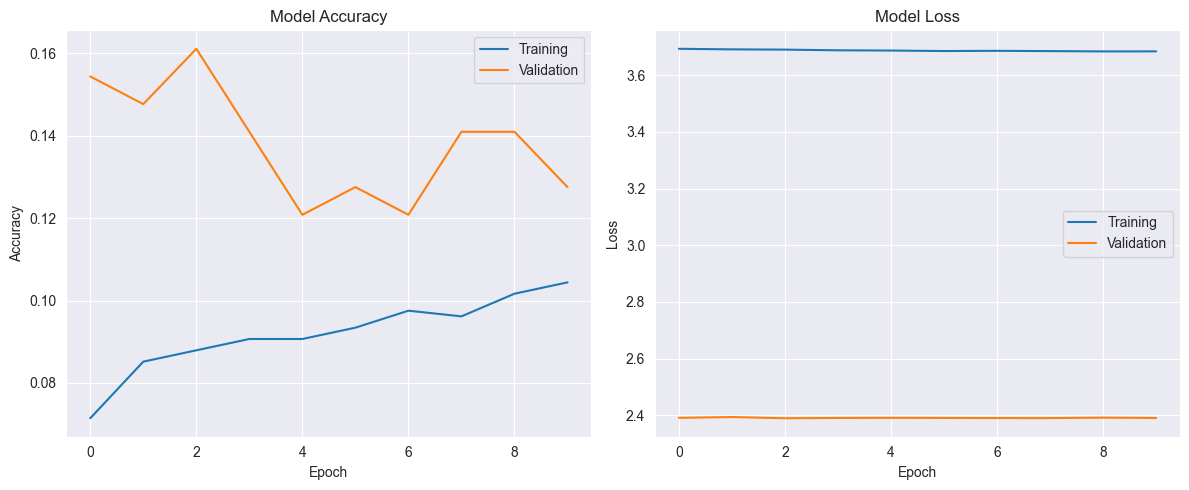

In [201]:
show_model_performance(history)